<a href="https://colab.research.google.com/github/EnhanceImpact/income-classifier-app/blob/main/ACS_Data_Modeling_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification Modeling

####Stratified K-Fold (n = 5)
* In 5-fold cross-validation, the data is split into five equal-sized folds.
* Each iteration uses 80% of the data for training and 20% for validation, rotating the test set each time.
* The “stratified” aspect ensures that each fold maintains the same class distribution as the full dataset.

# Step 1. Load the Data

In [ ]:
import pandas as pd

# Replace with the path to your uploaded file
df_clean = pd.read_csv("/content/ACSPUMS1Y2022_Georgia_Data_clean.csv")
df_clean.head()



,TEN,RAC1P,CIT,SCHL,BLD,HUPAC,COW,MAR,SEX,VEH,WKL,AGEP,NPF,GRPIP,WKHP,income
0,NaN,Black,Born in US,High School Graduate,NaN,NaN,State government,Never married,Male,NaN,1,27,1,0,48,<=50K
1,NaN,White,Born in US,Some College,NaN,NaN,Self-employed,Never married,Female,NaN,1,19,1,0,50,<=50K
2,NaN,White,Born in US,Some College,NaN,NaN,State government,Never married,Female,NaN,1,21,1,0,8,<=50K
3,NaN,Asian,Naturalized,High School Graduate,NaN,NaN,Self-employed,Never married,Male,NaN,1,25,1,0,45,<=50K
4,NaN,Tribes Specified,Not a citizen,Grade 9-12 (no diploma),NaN,NaN,Private nonprofit,Married,Male,NaN,1,47,1,0,52,<=50K


In [ ]:
#@title 2. Modeling with Grid Search & K-Fold Cross Validation Using Smote to handle class imbalance
# smote_modeling.py

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import joblib


# # Sanitize column names for compatibility with XGBoost
# df_encoded.columns = df_encoded.columns.str.replace('[<>\[\](){}]', '', regex=True).str.replace(' ', '_')

# Encode categorical features
df_encoded = pd.get_dummies(df_clean, drop_first=True).astype(int)

# Split into features and target
X = df_encoded.drop(['income_>50K'], axis=1)
y = df_encoded['income_>50K']




# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Set up Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --------------------------
# Logistic Regression
# --------------------------
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=2000))])
logreg_params = {'clf__C': [0.1, 1, 10]}

logreg_grid = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=logreg_params,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1
)
logreg_grid.fit(X_resampled, y_resampled)
print("\n✅ Logistic Regression")
print("Best Accuracy:", logreg_grid.best_score_)
print("Best Params:", logreg_grid.best_params_)

# --------------------------
# Random Forest
# --------------------------
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_params = {
    'n_estimators': [200, 250, 300],
    'max_depth': [None, 10, 20, 30]
}

rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=rf_params,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1
)
rf_grid.fit(X_resampled, y_resampled)
print("\n🌲 Random Forest")
print("Best Accuracy:", rf_grid.best_score_)
print("Best Params:", rf_grid.best_params_)

# --------------------------
# XGBoost
# --------------------------
xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 9]
}

xgb_grid = GridSearchCV(
    estimator=xgb,
    param_grid=xgb_params,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1
)
xgb_grid.fit(X_resampled, y_resampled)
print("\n🚀 XGBoost")
print("Best Accuracy:", xgb_grid.best_score_)
print("Best Params:", xgb_grid.best_params_)



✅ Logistic Regression
Best Accuracy: 0.7992752911125597
Best Params: {'clf__C': 10}


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



🌲 Random Forest
Best Accuracy: 0.8189431453941355
Best Params: {'max_depth': 20, 'n_estimators': 300}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [02:50:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🚀 XGBoost
Best Accuracy: 0.8215467505530212
Best Params: {'max_depth': 6, 'n_estimators': 200}


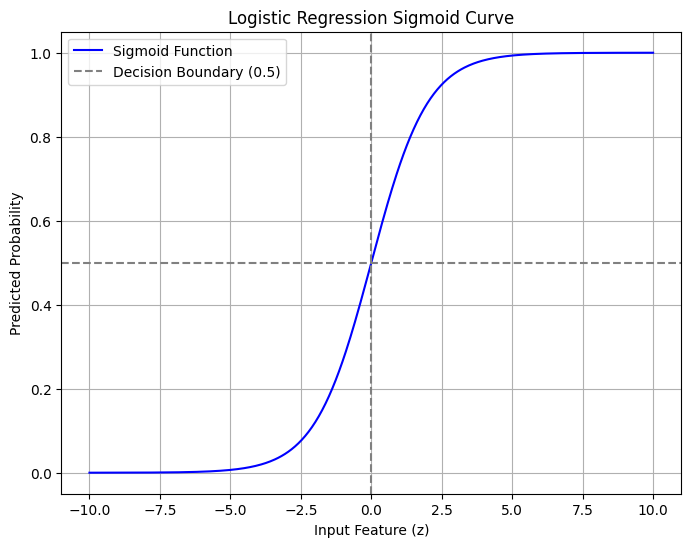

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit  # vectorized logistic (sigmoid) function

# Generate X values (feature space for visualization)
X_range = np.linspace(-10, 10, 500)
y_sigmoid = expit(X_range)  # sigmoid curve

# Plot S-Curve
plt.figure(figsize=(8, 6))
plt.plot(X_range, y_sigmoid, label='Sigmoid Function', color='blue')
plt.axhline(0.5, color='gray', linestyle='--', label='Decision Boundary (0.5)')
plt.axvline(0, color='gray', linestyle='--')
plt.title('Logistic Regression Sigmoid Curve')
plt.xlabel('Input Feature (z)')
plt.ylabel('Predicted Probability')
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


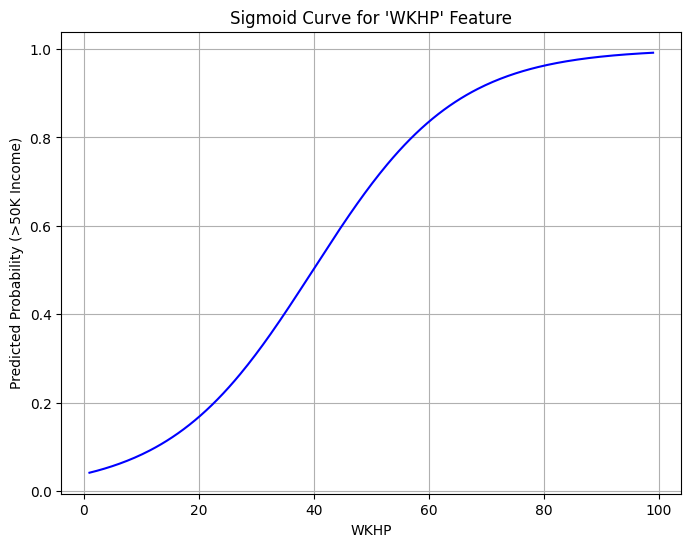

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get the best model from GridSearchCV
best_logreg = logreg_grid.best_estimator_

# Choose one feature to plot
feature_idx = 4  # change index to pick a different feature
feature_name = X_resampled.columns[feature_idx]

# Create a range of values for the chosen feature
feature_range = np.linspace(
    X_resampled[feature_name].min(),
    X_resampled[feature_name].max(),
    300
)

# Create a baseline (mean of all features)
baseline = X_resampled.mean().values.reshape(1, -1).repeat(300, axis=0)

# Replace chosen feature column with range
baseline[:, feature_idx] = feature_range

# Get predicted probabilities for class 1 (>50K)
probabilities = best_logreg.predict_proba(baseline)[:, 1]

# Plot sigmoid curve
plt.figure(figsize=(8, 6))
plt.plot(feature_range, probabilities, color="blue")
plt.title(f"Sigmoid Curve for '{feature_name}' Feature")
plt.xlabel(feature_name)
plt.ylabel("Predicted Probability (>50K Income)")
plt.grid(True)
plt.show()


In [ ]:
#@title 3. Review of Data After Encoding Categorical Features
#pd.set_option('display.max_columns', 100)
df_encoded.head()

In [ ]:
#@title 4. Visual Comparison of Accuracy scores for the Different Models
import matplotlib.pyplot as plt
model_scores = {
    'Logistic Regression': logreg_grid.best_score_,
    'Random Forest': rf_grid.best_score_,
    'XGBoost': xgb_grid.best_score_
}

# Bar plot of model performance
plt.figure(figsize=(8, 5))
plt.bar(model_scores.keys(), model_scores.values(), color='skyblue')
plt.title('Model Accuracy Comparison')
plt.ylabel('Cross-Validated Accuracy')
plt.ylim(0.7, 0.9)
plt.show()

In [ ]:
#@title 5. Accuracy Analysis for Best Fitting Model
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Evaluation for Best Model: Random Forest
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Best Model
best_model = xgb_grid.best_estimator_
# Drop 'fnlwgt', 'capital-gain', and 'capital-loss' from the features
X = X.drop(columns=['fnlwgt', 'capital-gain', 'capital-loss'], errors='ignore')

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Use the best model from grid search
# best_model = xgb_grid.best_estimator_
best_model.fit(X_train, y_train)

# Predict probabilities and labels
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend()
plt.grid()
plt.show()

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title('Confusion Matrix - XGBoost')
plt.show()

# Classification Report
print("Classification Report - XGBoost")
print(classification_report(y_test, y_pred))

In [ ]:
# @title 6. Feature Importance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Make sure you're referencing the best trained XGBoost model
xgb_model = xgb_grid.best_estimator_

# Get feature importances
importances = xgb_model.feature_importances_
feature_names = X.columns

# Create DataFrame of feature importances
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort and select top 15
feat_df = feat_df.sort_values(by='Importance', ascending=False).head(15)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_df['Feature'], feat_df['Importance'], color='goldenrod')
plt.gca().invert_yaxis()
plt.title('Top 15 Feature Importances - XGBoost')
plt.xlabel('Importance')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#@title 7. Save the best model
joblib.dump(xgb_grid.best_estimator_, "income_model.pkl")
joblib.dump(X.columns.tolist(), "model_features.pkl")